In [9]:
from amftrack.util.sys import get_analysis_folders, get_time_plate_info_long_from_analysis
import pandas as pd

%load_ext autoreload
%autoreload 2
import logging
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
logging.getLogger().setLevel(logging.WARNING)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

all_analysis_folders = get_analysis_folders("data")
#for P
plates = [
"416_20230705",
"427_20230707",
"420_20230705",
"431_20230627",
"474_20230807",
"460_20230807",
"464_20230807",
"440_20230723",
"436_20230717",
"443_20230720",
"439_20230804",
"470_20230709",
'478_20230814', '468_20230809', '447_20230821', '487_20230922',
       '492_20230901', '471_20230821', '486_20231009',
       '494_20230908', '482_20230908', '495_20231013', '463_20231013',
       '491_20231013', '481_20231005', '483_20231005',
    '490_20231003',
       '485_20230929',
]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import shutil
destination_path = r"C:\Users\coren\Documents\PhD\paper\travelling_wave\AMFTravellingWave\Figure_plots\data"

# Define a function to specify ignored folders
def ignore_folders(directory, contents):
    # Ignore "validation" and "time_edge_info" folders
    return [folder for folder in contents if folder in {"validation", "time_edge_info","experiment.pick"}]

# Iterate over each folder path in the 'total_path' column
for folder_path in analysis_folders['total_path']:
    # Extract the folder name from the path
    folder_name = os.path.basename(folder_path.rstrip('/'))
    
    # Define the new path in the destination
    dest_folder = os.path.join(destination_path, folder_name)
    if not os.path.exists(dest_folder):
    # Copy the folder to the destination path, ignoring specified folders
        shutil.copytree(folder_path, dest_folder, ignore=ignore_folders)

In [11]:
folders,time_plate_info = get_time_plate_info_long_from_analysis(analysis_folders,False)
time_plate_info['unique_id'] = time_plate_info['unique_id'].replace(47020230709,47020230802)
time_plate_info=time_plate_info[time_plate_info['Plate']!=431]


In [12]:
def calculate_integral(df, column, new_column):
    # Calculate the time difference within each group
    df['time_since_begin_hour'] = df['time_since_begin_h'].dt.total_seconds() / 3600.0
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_hour'].transform(lambda x: x.diff())

    # Calculate the average length density within each group
    df['avg_length_density'] = df.groupby('unique_id')[column].transform(lambda x: x.rolling(window=2).mean())

    # Calculate the "area" (using Trapezoidal rule) for each pair of rows within each group
    df['area'] = df['time_diff'] * df['avg_length_density']

    # Perform the integration (cumulative sum of "area") within each group
    df[new_column] = df.groupby('unique_id')['area'].transform(lambda x: x.cumsum())

    # Drop the helper columns if needed
    df.drop(['time_diff', 'avg_length_density', 'area'], axis=1, inplace=True)

In [13]:
for i in range(18):
    calculate_integral(time_plate_info,f'SA_region_{i}',f'integrated_SA_{i}')
for i in range(18):
    calculate_integral(time_plate_info,f'length_density_region_{i}',f'integrated_L_{i}')


In [14]:
coarse_to_basic_mapping = {
    1: [1, 2],
    2: [3, 8],
    3: [4, 5],
    4: [6, 7],
    5: [9, 10],
    6: [11, 12],
    7: [13],
    8: [14, 15],
    9: [16, 17, 18]
}

# Mapping for "simple" to "basic"
simple_to_basic_mapping = {
    0: list(range(1, 11)),
    1: list(range(11, 19))
}
sub_to_basic_mapping = {
    0: list(range(1, 19)),
}

In [15]:

%load_ext autoreload
%autoreload 2

%matplotlib widget
C_max2 = 1.53

def fit_function(x, C_max):
    return 1+C_max * 1/x**(3/2)
# Read the Excel file
path = r'C:\Users\coren\Documents\PhD\Pexperiment'
path_excel = os.path.join(path,'summary.xlsx')
df = pd.read_excel(path_excel)
df['date_from_unique_id'] = pd.to_datetime(df['unique_id'].str.split('_').str[1], format='%Y%m%d')
    
# Convert 'day' column to datetime
df['day_sample'] = pd.to_datetime(df['day_sample'], format='%Y%m%d')  # Update the format as necessary
df['day_start'] = pd.to_datetime(df['start'], format='%Y%m%d')  # Update the format as necessary

df['time_elapsed'] = df['day_sample'] - df['day_start']
df['time_elapsed_day'] = df['time_elapsed'].dt.days
df['time_since_crossing'] = df['day_sample'] - df['date_from_unique_id']
df['t2 (day)'] = df['time_since_crossing'].dt.days
df['t1 (day)'] = df['time_elapsed_day']-df['t2 (day)']
df['treatment'] = df['treatment'].fillna('none')
df['wet_weight_measured'] = df['wet weight']

df['wet weight'] = df['wet weight']-df['lost weight']
df['totP (ug)'] = df['totP (ug)'] * fit_function(df['totP (ug)'], C_max2)
df['Sample_name'] = df['Sample_name'].str.replace('bottom','0')
df['Sample_name'] = df['Sample_name'].str.replace('up','1')
df['Sample_name'] = df['Sample_name'].str.replace('top','1')
df['Sample_name'] = df['Sample_name'].str.replace('agar','0')



df = df.loc[df['plate']!=487]
df = df.loc[df['type'] == 'agar']
df['pos'] = df['Sample_name'].str.split('-').str.get(1).astype(int)

time_plate_info.sort_values(['unique_id', 'time_since_begin_h'], inplace=True)

# Group by unique_id and take the last entry for each group
last_values = time_plate_info.groupby('unique_id').last().reset_index()

# Create a function to map 'pos' to the corresponding integrated_Ldens_i value
def get_integrated_density(row):
    unique_id = row['unique_id']
    pos = row['pos']
    arrangement = row['arrangement']
    if arrangement == 'basic':
        col_names = [f'integrated_SA_{pos-1}']
    if arrangement == 'simple':
        col_names = [f'integrated_SA_{basic_pos-1}' for basic_pos in simple_to_basic_mapping[pos]]
    if arrangement == 'coarse':
        col_names = [f'integrated_SA_{basic_pos-1}' for basic_pos in coarse_to_basic_mapping[pos]] 
    if arrangement == 'sub':
        col_names = [f'integrated_SA_{basic_pos-1}' for basic_pos in sub_to_basic_mapping[pos]] 
    if not unique_id is np.nan:
        last_value_row = last_values[last_values['unique_id'] == int(unique_id)]
        return np.sum(last_value_row[col_names].values) if not last_value_row.empty else None
    else:
        return(None)
df['integrated_SA'] = df.apply(get_integrated_density, axis=1)

grouped = df.groupby(['plate', 'type', "time_elapsed_day", "t1 (day)", "treatment", 't2 (day)', "arrangement","day_start"]).agg({
    'totP (ug)': 'sum',
    'wet weight': ['sum', 'median'],
    "wet_weight_measured":"sum",
    'dry weight': 'sum',
    'integrated_SA':"sum"
}).reset_index()

# Rename columns
grouped.columns = ['_'.join(col).strip() if col[0] == 'wet weight' else col[0] for col in grouped.columns]
grouped = grouped.rename(columns={
    'wet weight_sum': 'tot_wet_weight',
    'wet weight_median': 'wet_weight_median'
})
grouped['C_P'] = grouped['totP (ug)'] / grouped['tot_wet_weight']
grouped['P_content'] = grouped['totP (ug)'] / grouped['dry weight']/1e6

df['C_P'] = df['totP (ug)'] / df['wet weight']
df['P_content'] = df['totP (ug)'] / df['dry weight']/1e6
# df = df[df['type'] != 'sub']

grouped = grouped[grouped['plate']!=487]

df['integrated_SA_C']=df['integrated_SA']/df['wet weight']
# grouped = dfgrouped = df.groupby(['plate', 'type',"time_elapsed_day","t1 (day)","treatment",'t2 (day)']).agg({'totP (ug)': 'sum', 'wet weight': 'sum','dry weight' : "sum",'integrated_SA':"sum"}).reset_index()
grouped['C_P'] = grouped['totP (ug)'] / grouped['tot_wet_weight']
grouped['P_content'] = grouped['totP (ug)'] / grouped['dry weight']/1e6
grouped['integrated_SA_C']=grouped['integrated_SA']/grouped['tot_wet_weight']
tot_weights = grouped[grouped['type'].isin(["agartot", "rootagartot"])].set_index(['plate', 'type'])['wet_weight_measured'].to_dict()

# Function to determine the 'measured_tot_wet_weight' based on conditions
def get_tot_weight(row):
    if row['type'] == 'agar' and (row['plate'], 'agartot') in tot_weights:
        return tot_weights[(row['plate'], 'agartot')]
    elif row['type'] == 'rootagar' and (row['plate'], 'rootagartot') in tot_weights:
        return tot_weights[(row['plate'], 'rootagartot')]
    else:
        return row['wet_weight_measured']

# Apply the function to get 'measured_tot_wet_weight' column
grouped['measured_tot_wet_weight'] = grouped.apply(get_tot_weight, axis=1)
grouped= grouped[grouped['type'] != 'rootagartot']
grouped= grouped[grouped['type'] != 'agartot']
# Step 1: Identify plates that don't have any rows with type "agartot"
plates_with_agartot = grouped[grouped['type'] == 'rootagartot']['plate'].unique()
valid_plates = grouped[~grouped['plate'].isin(plates_with_agartot)]

# Step 2: Compute the average "wet weight" for type 'agar' and 'rootagar'
average_wet_weight_agar = valid_plates[valid_plates['type'] == 'agar']['measured_tot_wet_weight'].mean()
average_wet_weight_rootagar = valid_plates[valid_plates['type'] == 'rootagar']['measured_tot_wet_weight'].mean()

# Step 3: Replace rows in the 'average weight' column accordingly
grouped['average weight'] = None  # Initialize column with None values
grouped.loc[grouped['type'] == 'agar', 'average weight'] = average_wet_weight_agar
grouped.loc[grouped['type'] == 'rootagar', 'average weight'] = average_wet_weight_rootagar
grouped.loc[grouped['type'] == 'agar', 'fullP'] = grouped.loc[grouped['type'] == 'agar', 'measured_tot_wet_weight'] *grouped.loc[grouped['type'] == 'agar', 'C_P']
grouped.loc[grouped['type'] == 'rootagar', 'fullP'] = grouped.loc[grouped['type'] == 'rootagar', 'measured_tot_wet_weight'] *grouped.loc[grouped['type'] == 'rootagar', 'C_P']
grouped.loc[grouped['type'] == 'root', 'fullP'] = grouped.loc[grouped['type'] == 'root', 'totP (ug)']
totP_theory = 100
grouped['scaling_factor'] = totP_theory/grouped.groupby('plate')['fullP'].transform('sum')

# Multiply 'fullP' by the scaling factor to get 'fullP_rescaled'
grouped['fullP_rescaled'] = grouped['fullP'] * grouped['scaling_factor']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


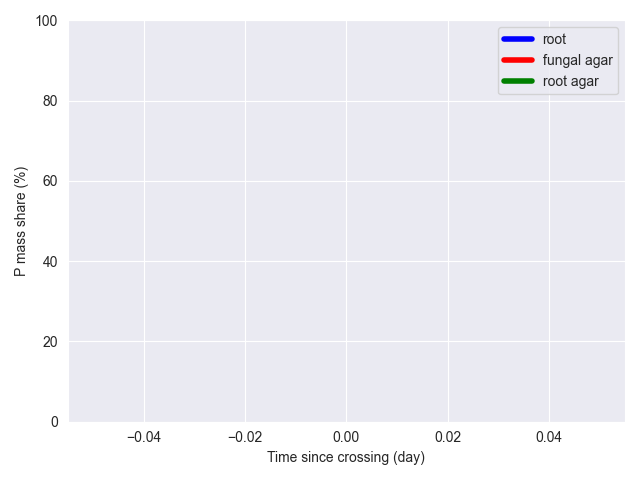

In [16]:
from matplotlib.lines import Line2D
select= grouped[grouped['fullP']>0]
select= select[select['treatment']=='100P']
select = select[select['plate']!=431]
select = select[select['plate']!=487]

t2_values = select['t2 (day)'].unique()
color_dict = {
    'root': 'blue',
    'agar': 'red',
    'rootagar': 'green'
}
# Plotting
fig, ax = plt.subplots()
blues = []
reds = []
greens = []
t2s = []
for t2 in sorted(t2_values):
    plate_data = select[select['t2 (day)'] == t2]
    
    bottom = 0
    k=0
    for type_ in ['root', 'agar', 'rootagar']:
        value = plate_data[plate_data['type'] == type_]['fullP_rescaled'].mean()
            # print(t2,plate_data[plate_data['type'] == type_]['plate'])
        ax.bar(t2, value, bottom=bottom, color=color_dict[type_])
        bottom += value
   
        if k==0:
            blues.append(bottom)
        elif k==1:
            reds.append(bottom)
        else:
            greens.append(bottom)
        k+=1
    t2s.append(t2)
ax.fill_between(t2s,blues,color="blue",alpha = 0.3)
ax.fill_between(t2s,blues,reds,color="red",alpha = 0.3)
ax.fill_between(t2s,greens,reds,color="green",alpha = 0.3)

# Setting labels and title
ax.set_ylabel('fullP Value')
ax.set_xlabel('t2 Value')
ax.set_ylim(0,100)
color_dict = {
    'root': 'blue',
    'fungal agar': 'red',
    'root agar': 'green'
}
legend_elements = [Line2D([0], [0], color=color_dict[type_], lw=4, label=type_) for type_ in color_dict.keys()]
ax.legend(handles=legend_elements)
ax.set_ylabel('P mass share (%)')
ax.set_xlabel('Time since crossing (day)')
plt.tight_layout()

In [17]:
def set_r_value(row):
    if row['arrangement'] == 'basic':
        if 1 <= row['pos'] <= 5:
            return 0
        elif 6 <= row['pos'] <= 10:
            return 1
        elif 11 <= row['pos'] <= 15:
            return 2
        elif 16 <= row['pos'] <= 18:
            return 3
    elif row['arrangement'] == 'coarse':
        if 1 <= row['pos'] <= 3:
            return 0
        elif 4 <= row['pos'] <= 5:
            return 1
        elif 6 <= row['pos'] <= 8:
            return 2
        elif row['pos'] == 9:
            return 3
    elif row['arrangement'] == 'simple':
        if row['pos'] == 0:
            return 0.5
        elif row['pos'] == 1:
            return 2.5
    return None  # Default case if none of the conditions are met

# Apply the function to the DataFrame
df['r_value'] = df.apply(set_r_value, axis=1)
grouped_r = df.groupby(['plate', 'type', "time_elapsed_day", "t1 (day)", "treatment", 't2 (day)', "arrangement","day_start","r_value"]).agg({
    'totP (ug)': 'sum',
    'wet weight': ['sum', 'median'],
    "wet_weight_measured":"sum",
    'dry weight': 'sum',
    'integrated_SA':"sum"
}).reset_index()

# Rename columns
grouped_r.columns = ['_'.join(col).strip() if col[0] == 'wet weight' else col[0] for col in grouped_r.columns]
grouped_r = grouped_r.rename(columns={
    'wet weight_sum': 'tot_wet_weight',
    'wet weight_median': 'wet_weight_median'
})
grouped_r['C_P'] = grouped_r['totP (ug)'] / grouped_r['tot_wet_weight']


In [18]:
grouped_r['t2_coarse'] = grouped_r['t2 (day)']//3*3

grouped_r['rvalue_coarse'] = grouped_r['r_value']//2*2*2*10
grouped_r['C_P_0'] = grouped_r['C_P']-2
grouped_r['time (day)'] = grouped_r['t2_coarse'].apply(lambda x: 9 if x >= 9 else x)

# Creating the plot


Text(0, 0.5, '$[P]$ ($\\mu g/ mL$)')

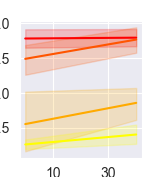

In [19]:
path_figure = r'C:\\Users\\coren\\AMOLF-SHIMIZU Dropbox\\HFSP_symbiotic-networks\\Article_TravellingWave\\Supplementary material\\extended_data_figures'

cm = 1/2.54  # centimeters in inches

fig,ax = plt.subplots(figsize = (4*cm,4.5*cm))
select = grouped_r[grouped_r['treatment']=='100P']
select = select[select['t2 (day)']<=30]
select = select[select['C_P']<=5]

select = select[select['arrangement'].isin(['coarse','basic','simple'])]
# select = select[select['arrangement'].isin(['coarse','basic'])]


# Creating the plot


# sns.scatterplot(select,x = 'r_value',y = 'C_P',ax = ax,hue ="t2 (day)")
sns.lineplot(select,x = 'rvalue_coarse',y = 'C_P_0',ax = ax,hue ="time (day)",estimator = "mean",palette="autumn",legend=False)
ax.set_xticks([10, 30])
ax.set_xlabel('$r$ ($mm$)')
ax.set_ylabel('$[P]$ ($\mu g/ mL$)')

### ED Fig. 5b,c
Requires installing dolfin 2019.2.0.dev0 which cannot easily be done within a poetry environment. The following cell will only run with that specific version of dolfin installed. This can be done using something like (the right dolfin version could only be find in bvpy source files...)
```
conda env create -f env.yaml -n bvpy-dev
```


In [20]:
DP = 1e-5 #cm**2-s-1, diffusion coefficient of small ions in water
DP = DP*1e2*3600 #mm**2-h-1, diffusion coefficient of small ions in water
C0 = 3.5 #ug/mL=ug/cm**-3
C0 = 3.5*1e-3 #ug/mm**-3
Vmax = 2e-5 #umol.cm-2/s-1
Vmax = Vmax*31 #ug.cm-2.s-1
Vmax = Vmax * 3600 #ug.cm-2.h-1
Vmax = Vmax *1e-2 #ug.mm-2.h-1
r0 = 5e-3 #mm
Km = 5e-3 #umol/cm3
Km *= 31 #ug/cm3
Km *=1e-3 #ug/mm3
Km_snchepf = Km
C0 = 500 #mg.L-1
C0 = 500*1e3 #ug.L-1
C0 = C0 * 1e-3 #ug.cm-3
C0 = C0 *1e-3 #ug.mm-3
from tqdm.notebook import tqdm  # Import tqdm
import matplotlib.ticker as ticker
cm = 1/2.54  # centimeters in inches
bp = 239
import matplotlib.pyplot as plt

plt.style.use('presentation.mplstyle')

from dolfin import *
import numpy as np
import matplotlib as mpl
cmap3 = mpl.cm.get_cmap("autumn")
cmap4 = mpl.cm.get_cmap("summer")

import os
Length = 140*1.5
nx = 350*15//10
plt.close("all")
set_log_active(False)
rho_value = 5
class Simulation:
    """
    A class for simulating a finite element problem using the FEniCS framework.

    Attributes:
    -----------
    Length: float
        Length of the interval domain.
    nx: int
        Number of subdivisions in the mesh.
    nT: int
        Number of time steps.
    T: float
        Total simulation time.
    C0: float
        Initial concentration value.
    Fmax: float
        Maximum flux value.
    Pprice_ideal: float
        Ideal price value.
    width: float
        Width of the plot.
    height: float
        Height of the plot.
    """
    def __init__(self, Length=Length, nx=nx, nT=200, T=400, C0=10, Fmax=2, Pprice_ideal=20, width=3*cm, height=7*cm,speed = 0.230,adaptation_rate = 1e-4,drag = 0):
        self.Length = Length
        self.nx = nx
        self.dx = Length/nx
        self.nT = nT
        self.T = T
        self.dt = T/nT
        self.C0 = C0 #ug.mm-3
        self.Fmax = Fmax
        self.Pprice_ideal = Pprice_ideal
        self.width = width
        self.height = height
        self.speed = speed
        self.adaptation_rate = adaptation_rate
        self.speed_penalty = drag
        self._setup_simulation()
        self.r0 = 3e-3

    def _setup_simulation(self):
        # Set up the simulation: define mesh, function spaces, initial conditions, etc.
        """
        Sets up the initial conditions and parameters for the simulation.
        """
        # Create mesh and define function space
        self.mesh = IntervalMesh(self.nx, 1, self.Length)
        P1 = FiniteElement('P', interval, 1)
        element = MixedElement([P1, P1, P1])
        self.V = FunctionSpace(self.mesh, element)

        # Define initial conditions
        u0 = Expression(('0.3*exp(-0.2*pow(abs(x[0]-7),2))', 
                         f'(1-exp(-0.1*(x[0]-1)))*{self.C0}', '0*exp(-0.01*pow(abs(x[0]),2))'), degree=1)
        rexp = Expression(('1/x[0]', '0', '0'), degree=1)
        self.r = interpolate(rexp, self.V)
        self.invr, _, _ = split(self.r)
        self.u_n = interpolate(u0, self.V)

        # Splitting functions for later use
        self.u = Function(self.V)
        self.n, self.C, self.rho = split(self.u)   #mm-3,ug.mm-3,mm2.mm-3
        self.n_n, self.C_n, self.rho_n = split(self.u_n)
        self.v_1, self.v_0, self.v_2 = TestFunctions(self.V)

        # Set parameters and constants
        self.dt = self.T / self.nT
        self.alphval = 0.039 #.h-1
        self.alphval0 = self.alphval
        self.betaval = 0.022 #mm.h-1 length coefficient
        # self.betaval = 0.022/(2.5e-3) #mm.h-1 SA coefficient
        
        self.beta = Constant(self.betaval) #mm**4.h-1
        self.D = 0.0008 #mm**2.h-1
        self.D0 = self.D #mm**2.h-1
        
        self.D2 = Constant(3.6) #mm**2.h-1
        self.n_mid = 0.5*(self.n_n + self.n)
        self.v_sval = self.speed #mm.h-1
        self.s_scal = self.speed #mm.h-1
        self.v_s = Constant((self.v_sval,)) #mm.h-1
        self.Vmax = self.Fmax #ug.mm**-2.h-1
        self.Kp = Km_snchepf #ug.mm-3
        # Boundary conditions
        u_L = (Constant(0.0), Constant(0.0), Constant(0.0))
        u_R = (Constant(0.0), Constant(self.C0), Constant(0.0))
        bc_L = DirichletBC(self.V, u_L, 'near(x[0], 1.0)')
        bc_R = DirichletBC(self.V, u_R, f'near(x[0], {self.Length})')
        self.bcs = [bc_L, bc_R]

    def _make_F(self, alphval,D,sval):
        # Define the variational problem F
        alpha = Constant(alphval)
        D = Constant(D)
        s_scal = Constant(sval)
        
        # dn/dt
        F = self.n*self.v_1*dx - self.n_n*self.v_1*dx 
        # D lapplacian(n)
        F += D*dot(grad(self.n), grad(self.v_1))*self.dt*dx
        # To account for cylindrical coordinates
        F += self.invr*D*dot(grad(self.n), Constant((1,)))*self.v_1*self.dt*dx
        
        #v.grad(n)
        F += self.dt*dot(grad(self.n_mid),self.v_s)*self.v_1*dx
        # To account for cylindrical coordinates
        F += self.invr*self.dt*self.n_mid*Constant(self.v_sval)*self.v_1*dx
        
        #alpha*n - beta * n * rho
        F += self.beta*self.v_1*self.rho*(self.n)*self.dt*dx
        F -= alpha*(self.n)*self.v_1*self.dt*dx
        #d rho/dt = vn
        F -= self.dt*s_scal*self.n*self.v_2*dx-(self.rho-self.rho_n)*self.v_2*dx


        # dC/dt
        F += self.C*self.v_0*dx - self.C_n*self.v_0*dx #ug.mm-3
        # Vmax * rho * C/(C+Kp)
        F += 2*np.pi*self.Vmax*(self.rho)*self.r0*(self.C/bp/(self.Kp+self.C/bp))*self.v_0*self.dt*dx #ug
        # Diffusion 
        F += self.D2*dot(grad(self.C/bp), grad(self.v_0))*self.dt*dx
        # To account for cylindrical coordinates
        F += self.invr*self.D2*dot(grad(self.C/bp), Constant((1,)))*self.v_0*self.dt*dx

        return F
    def integrate(self, plot=False,remove_ylabels = False):
        """
        Integrate the problem over time and optionally plot the results.
        Returns arrays of C(x, t), rho(x, t), and n(x, t) over the simulation.

        Parameters:
        -----------
        plot: bool
            If True, plot the results using matplotlib.

        Returns:
        --------
        C_xt: list of arrays
            Concentration C as a function of position x and time t.
        rho_xt: list of arrays
            Density rho as a function of position x and time t.
        n_xt: list of arrays
            Quantity n as a function of position x and time t.
        """
        # Initialize arrays to store C(x, t), rho(x, t), and n(x, t)
        C_xt = []
        rho_xt = []
        n_xt = []
        P_prices = []
        alphavals = []
        # Initialize matplotlib plots if needed
        if plot:
            fig, axs = plt.subplots(4, 1, figsize=(self.width, self.height*1.5))
            cmap = mpl.cm.get_cmap("winter")
            cmap2 = mpl.cm.get_cmap("spring")

        # Time-stepping loop
        V2 = FunctionSpace(self.mesh, 'P', 1)
        X = np.linspace(1, self.Length, self.nx)
        i=0
        for t in tqdm(np.linspace(0, self.T, self.nT), desc="Simulating"):
            F = self._make_F(self.alphval,self.D,self.s_scal)
            solve(F == 0, self.u, self.bcs)
            self.u_n.assign(self.u)
            _n, _C, _rho = self.u.split()

            # Interpolate and store the results
            n_field = interpolate(_n, V2)
            rho_field = interpolate(_rho, V2)
            C_field = interpolate(_C, V2)
            Ccost = np.sum([n_field(x)*x*self.dx*self.v_sval for x in X]) #mm.h-1.mm-1
            Ccost *= np.pi*(self.r0)**2 #mm**3.mm-1.h-1
            Ccost *= 1e-3  #mL.mm-1.h-1=dm**3.mm-1.h-1
            
            Ccost *= 0.5*0.21*1.1 #g.mm-1.h-1
            Ccost *= 1e6 #ug.mm-1.h-1
            Ccost *= 2 #respiration
            Ccost *= (self.v_sval/0.25)**(self.speed_penalty)
            Pacquisition = np.sum([self.Vmax*(C_field(x)/bp/(C_field(x)/bp+self.Kp))*rho_field(x)*x*self.dx for x in X]) #ug.h-1.mm-2
            Pacquisition *= 2*self.r0*np.pi #ug.h-1.mm-1
            # Pacquisition += 5e-4*np.exp(-t/100)
            
            Pprice = Ccost/Pacquisition

            alphavals.append(self.alphval)
            # if t>=10:
                # self.s_scal = self.Pprice_ideal/Pprice*self.speed
                # self.alphval = max(0.001,self.alphval + self.dt*self.adaptation_rate*signed_sqrt((self.Pprice_ideal-Pprice)/self.Pprice_ideal,alpha = 1))
            # print(self.alphval)
            self.D = self.D0*self.alphval0/self.alphval
            # print(2*(np.sqrt(self.D*self.alphval)))
            n_xt.append([n_field(x) for x in X])
            rho_xt.append([rho_field(x) for x in X])
            C_xt.append([C_field(x) for x in X])
            P_prices.append(Pprice)
            # print(Pprice,self.alphval)
            if plot and i % (self.nT//5) == 0:
                axs[1].plot(X, n_xt[-1], color=cmap2(t / self.T))
                axs[0].plot(X, rho_xt[-1], color=cmap(t / self.T))
                axs[2].plot(X, np.array(C_xt[-1])*1000, color=cmap3(t / self.T))
                Pacq =  [2*self.r0*np.pi*C_xt[-1][i]/bp/(C_xt[-1][i]/bp+self.Kp) * rho_xt[-1][i]*Vmax*1000 for i in range(len(X))]
                
                axs[3].plot(X, Pacq, color=cmap4(t / self.T))
                # break
            i+=1
            

        # Finalize plot settings if plotting
        if plot:
            axs[1].plot(X, n_xt[-1], color=cmap2(t / self.T))
            axs[0].plot(X, rho_xt[-1], color=cmap(t / self.T))
            satrho = np.median([rho for rho in rho_xt[-1] if rho>1e-10])
            
            # axs[0].hlines(satrho,np.min(X),np.max(X), color="red")
            
            axs[2].plot(X, np.array(C_xt[-1])*1000, color=cmap3(t / self.T))
            Pacq =  [2*self.r0*np.pi*C_xt[-1][i]/bp/(C_xt[-1][i]/bp+self.Kp) * rho_xt[-1][i]*Vmax*1000 for i in range(len(X))]
            axs[3].plot(X, Pacq, color=cmap4(t / self.T))
            axs[0].set_ylabel(r'$\rho$'+ '\n $(mm^{-2})$')
            axs[0].set_xticklabels([])
            # axs[0].set_ylim(0,3.5)
            
            axs[1].set_ylabel('$n$ \n $(mm^{-3})$')
            axs[1].set_xticklabels([])
            # axs[1].set_ylim(0,1.5)
            
            axs[2].set_ylabel('$[P]$ \n ($ng/ mm^{3}$)')
            axs[2].set_xticklabels([])
            
            axs[3].set_ylabel('$\phi_P$ \n ($ng/mm^{3}/h$)')

            axs[3].set_xlabel('position \n ($mm$)')
            # axs[3].set_ylim(0,0.60)

            formatter = ticker.FormatStrFormatter('%.2f')  # Adjust format as needed

            for ax in axs:
                ax.yaxis.set_major_formatter(formatter)
            if remove_ylabels:
                for ax in axs:
                    ax.set_ylabel('')
                    ax.set_yticklabels([])

            plt.show()

        return C_xt, rho_xt, n_xt,P_prices,alphavals
    
cm = 1/2.54  # centimeters in inches


# Example usage:
C0=0.02 #ug.mm-3
Pprice_ideal = C0/C0**(1/3)
speed = 0.10
sim = Simulation(speed = speed,C0=C0,T = 600,nT=600,Pprice_ideal = Pprice_ideal,Fmax = Vmax,adaptation_rate = 3e-4,drag = 1, width=6*cm, height=4*cm)
C_xt, rho_xt, n_xt,P_prices,alphavals = sim.integrate(plot=True)

OSError: 'presentation.mplstyle' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [ ]:
def get_P_cost(C_xt, rho_xt, n_xt,sim):
    C_xt, rho_xt, n_xt = np.array(C_xt),np.array(rho_xt),np.array(n_xt)    
    X = np.linspace(1, sim.Length, sim.nx)
    dx = Length/nx
    Pacquisitions = np.sum(Vmax*(C_xt/bp/(C_xt/bp+sim.Kp))*rho_xt*X*sim.dx,axis=1) #ug.h-1.mm-1
    Pacquisitions *= 2*sim.r0*np.pi
    Ccost = np.sum(n_xt*X*sim.dx*sim.v_sval,axis=1) #mm.h-1.mm-1
    Ccost *= np.pi*(sim.r0)**2 #mm**3.mm-1.h-1
    Ccost *= 0.5*0.21 *1e-3 #g.mm-1.h-1
    Ccost *= 1.1e6 #ug.mm-1.h-1
    Ccost *= 2 #respiration
    return(np.sum(Ccost)/np.sum(Pacquisitions))

def get_P_acqu(C_xt, rho_xt, n_xt,sim):
    C_xt, rho_xt, n_xt = np.array(C_xt),np.array(rho_xt),np.array(n_xt)    
    X = np.linspace(1, sim.Length, sim.nx)
    dx = Length/nx
    Pacquisitions = np.sum(Vmax*(C_xt/bp/(C_xt/bp+sim.Kp))*rho_xt*X*sim.dx,axis=1) #ug.h-1.mm-2
    Pacquisitions *= 2*sim.r0*np.pi*sim.dt
    return(np.sum(Pacquisitions))

In [ ]:
mini = 0.05
maxi = 0.3
resolution = 10
speeds = np.exp(np.linspace(np.log(mini),np.log(maxi),resolution))
Pcosts = []
Pacqus = []

for speed in speeds:
    sim = Simulation(speed = speed,C0=C0,T = 600,nT=600,Pprice_ideal = Pprice_ideal,Fmax = Vmax,adaptation_rate = 3e-4,drag = 1, width=6*cm, height=4*cm)
    C_xt, rho_xt, n_xt,P_prices,alphavals = sim.integrate(plot=False)
    Pcosts.append(get_P_cost(C_xt, rho_xt, n_xt,sim))
    Pacqus.append(get_P_acqu(C_xt, rho_xt, n_xt,sim))                

In [ ]:
fig,ax = plt.subplots(2,1,sharex=True,figsize = (4*cm,4.396))

ax[0].plot(1000*speeds,Pacqus)
ax[1].plot(1000*speeds,Pcosts)
ax[1].set_xlabel('$v_{wave}$ ($\mu m/h$)')
ax[1].set_ylabel('$\pi$ ($\mu gC/ \mu gP$)')
ax[0].set_ylabel('$m_P$ ($\mu gP/mm$)')
